# Forward Neuron AutoEncoder - Dimensionality Reduction of CIFAR100 FASHION DataSet
Compare the lossy ratio between multiple latent spaces

In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy


You should consider upgrading via the '/media/programming/projects/machineLearning/ML/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os.path
import PIL
import PIL.Image
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier


/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Import all Modules and Configure GPU

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist, fashion_mnist
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable float16 bit for improved performance.
        mixed_precision.set_global_policy('mixed_float16')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-07-28 06:26:33.619487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 06:26:33.641355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 06:26:33.641513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 06:26:33.642347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


## Load DataSet

In [5]:

def loadDataCifar100():
    (train_images, train_labels), (test_images,
                                   test_labels) = tf.keras.datasets.cifar100.load_data(label_mode='fine'
                                                                                       )

    class_names = [
        "apple",
        "aquarium_fish",
        "baby",
        "bear",
        "beaver",
        "bed",
        "bee",
        "beetle",
        "bicycle",
        "bottle",
        "bowl",
        "boy",
        "bridge",
        "bus",
        "butterfly",
        "camel",
        "can",
        "castle",
        "caterpillar",
        "cattle",
        "chair",
        "chimpanzee",
        "clock",
        "cloud",
        "cockroach",
        "couch",
        "crab",
        "crocodile",
        "cup",
        "dinosaur",
        "dolphin",
        "elephant",
        "flatfish",
        "forest",
        "fox",
        "girl",
        "hamster",
        "house",
        "kangaroo",
        "keyboard",
        "lamp",
        "lawn_mower",
        "leopard",
        "lion",
        "lizard",
        "lobster",
        "man",
        "maple_tree",
        "motorcycle",
        "mountain",
        "mouse",
        "mushroom",
        "oak_tree",
        "orange",
        "orchid",
        "otter",
        "palm_tree",
        "pear",
        "pickup_truck",
        "pine_tree",
        "plain",
        "plate",
        "poppy",
        "porcupine",
        "possum",
        "rabbit",
        "raccoon",
        "ray",
        "road",
        "rocket",
        "rose",
        "sea",
        "seal",
        "shark",
        "shrew",
        "skunk",
        "skyscraper",
        "snail",
        "snake",
        "spider",
        "squirrel",
        "streetcar",
        "sunflower",
        "sweet_pepper",
        "table",
        "tank",
        "telephone",
        "television",
        "tiger",
        "tractor",
        "train",
        "trout",
        "tulip",
        "turtle",
        "wardrobe",
        "whale",
        "willow_tree",
        "wolf",
        "woman",
        "worm"]

    TrainX = np.concatenate((train_images, test_images))
    TrainY = np.squeeze(np.concatenate((train_labels, test_labels)))

    TrainX = TrainX / 255.0

    return TrainX, TrainY, class_names


In [6]:

EPOCHS = 192
BUFFER_SIZE = 192
BATCH_SIZE = 96

trainAug = tf.keras.Sequential([
    layers.Rescaling(1.0 / 255.0),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    layers.RandomRotation(0.3)
])

trainX, trainY, classes = loadDataCifar100()
trainDS = tf.data.Dataset.from_tensor_slices((trainX, trainX))
trainAugmentedDS = (
    trainDS
    .shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (trainAug(x), y),
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_size = len(trainAugmentedDS)
train_size = int(0.8 * ds_size)
val_size = int(0.2 * ds_size)

val_ds = trainAugmentedDS.skip(train_size).take(val_size)

IMAGE_SIZE = trainX[0].shape


2022-07-28 06:26:33.969553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 06:26:33.970772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 06:26:33.970983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 06:26:33.971113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Show Example of DataSet

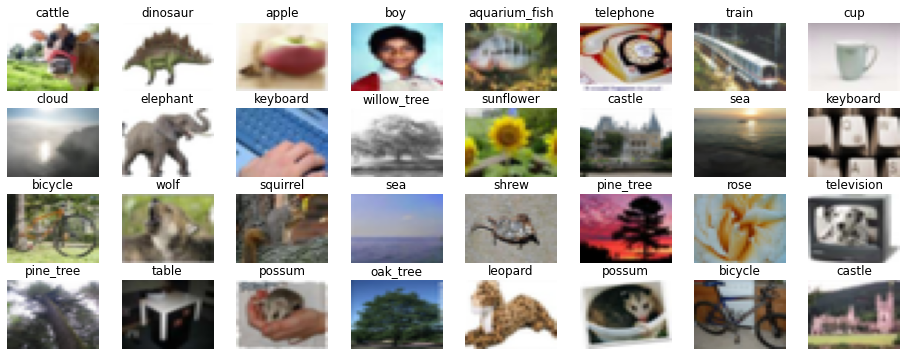

In [7]:
fig = plt.figure(figsize=(16, 6))
nrImage = 4 * 8
for index, (image, label) in enumerate(zip(trainX[0:nrImage], trainY[0:nrImage])):
    plt.subplot(4, 8, (index + 1))
    plt.title(label=str.format("{0}", classes[label]))

    plt.imshow(X=image.astype(dtype='float32'), cmap=plt.cm.gray, aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


# Create Dimensionality Reduction Model

In [8]:
def model_constructor(hp, latent_space, image_size):

    class Autoencoder(keras.Model):
        def __init__(self, hp, **kwargs):
            super(Autoencoder, self).__init__(**kwargs)

            activation_dict = {
                'leaky_relu': layers.LeakyReLU(alpha=0.2, dtype='float32'),
                'relu': layers.ReLU(dtype='float32')
            }
            batch_norm = hp.Boolean('batch_norm')

            kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                           'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
            kernel_activation = hp.Choice('kernel_activation', ['relu', 'leaky_relu'])

            hp_kernel_filter_size_l1 = hp.Int('kernel_filter', min_value=7, max_value=7, step=1)
            hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)
            num_downscale = hp.Int('num_downscale', min_value=1, max_value=2, step=1)

            number_layers = hp.Int(
                'number_layers', min_value=1, max_value=2, step=1)

            regularization = hp.Int(
                'regularization', min_value=4, max_value=5, step=1)
            use_upscale = hp.Boolean('Upscale')

            self.encoder = tf.keras.Sequential(name="Encoder")
            self.encoder.add(layers.Input(image_size))

            encoder_last_conv2 = None
            for i in range(0, number_layers):
                filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

                for j in range(0, num_downscale):
                    self.encoder.add(layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                                                   padding='same', strides=(2, 2), kernel_initializer=kernel_init))
                    self.encoder.add(activation_dict[kernel_activation])
                    if batch_norm:
                        self.encoder.add(layers.BatchNormalization())

                #
                encoder_last_conv2 = layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                                                   strides=(1, 1), padding='same', kernel_initializer=kernel_init)
                self.encoder.add(encoder_last_conv2)
                if batch_norm:
                    self.encoder.add(layers.BatchNormalization())
                self.encoder.add(activation_dict[kernel_activation])

            connect_conv_shape = encoder_last_conv2.output_shape

            # Flatten to connect to forward neuron.
            self.encoder.add(layers.Flatten())

            self.encoder.add(layers.Dense(units=latent_space, activation=activation_dict[kernel_activation], dtype='float32', name="latentspace"))

            # For adding sparse, for improve of thing with small variance.
            self.encoder.add(layers.ActivityRegularization(l1=10 ** -regularization, dtype='float32'))

            # Create decoder.
            self.decoder = tf.keras.Sequential(name="Decoder")

            self.decoder.add(layers.Dense(units=(connect_conv_shape[1] * connect_conv_shape[2] * connect_conv_shape[3]), dtype='float32'))
            self.decoder.add(activation_dict[kernel_activation])

            self.decoder.add(layers.Reshape(target_shape=(
                connect_conv_shape[1], connect_conv_shape[2], connect_conv_shape[3])))

            for i in range(0, number_layers):
                filter_size = 2 ** ((hp_kernel_filter_size_l1 - number_layers) + i + 1)

                self.decoder.add(layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                                 strides=(1, 1), padding='same', kernel_initializer=kernel_init))
                if batch_norm:
                    self.decoder.add(layers.BatchNormalization())
                self.decoder.add(activation_dict[kernel_activation])

                for j in range(0, num_downscale):
                    if use_upscale:
                        self.decoder.add(layers.Conv2DTranspose(filters=filter_size, kernel_size=hp_kernel_size,
                                                                padding='same', strides=(2, 2), kernel_initializer=kernel_init))
                    else:
                        self.decoder.add(layers.UpSampling2D(size=(2, 2)))
                    if batch_norm:
                        self.decoder.add(layers.BatchNormalization())
                    self.decoder.add(activation_dict[kernel_activation])

            self.decoder.add(layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init))
            if batch_norm:
                self.decoder.add(layers.BatchNormalization())
            self.decoder.add(layers.Activation(activation='sigmoid', dtype='float32'))

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

        def getEncoder(self):
            return self.encoder

        def getDecoder(self):
            return self.decoder

        def getModel(self):
            ae_input = layers.Input(shape=image_size, name="AE_input")
            ae_encoder_output = self.getEncoder()(ae_input)
            ae_decoder_output = self.getDecoder()(ae_encoder_output)

            return keras.Model(inputs=ae_input, outputs=ae_decoder_output)

        def compile(self, **kwargs):
            super(Autoencoder, self).compile(**kwargs)

        def summary(self, **kwargs):
            super(Autoencoder, self).summary(**kwargs)
            self.encoder.summary()

    autoencoder = Autoencoder(hp)
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])
    hp_learning_rate = hp.Choice('learning_rate', values=[2e-2, 2e-3, 2e-4])

    hp_loss = hp.Choice('loss', ['mse', 'binary_crossentropy'])

    optimizer = tf.keras.optimizers.get(hp_optimizer)
    optimizer.learning_rate = hp_learning_rate

    autoencoder.compile(optimizer=optimizer, loss=hp_loss, metrics=['accuracy'])

    return autoencoder


## Hyperparameter
Find the best model out of all the parameters.

In [ ]:

image_shape = (trainX[0].shape[0], trainX[0].shape[1], 3)

latent_spaces = [1, 2, 4, 8, 16, 32, 64, 128]
ae_models = []

for latent_space in latent_spaces:

    def hyperparamter_model_builder(hp):
        model = model_constructor(hp, latent_space, image_shape)
        return model

    tuner = kt.Hyperband(hyperparamter_model_builder,
                         objective='val_accuracy',
                         max_epochs=16,
                         factor=4,
                         directory='cache',
                         project_name=str.format('CIFAR100 AutoEncoder Reconstruct L{0} - {1}', latent_space, "Dimension Reduction"))

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=4)

    tuner.search(trainAugmentedDS, epochs=EPOCHS, shuffle=True, batch_size=BATCH_SIZE,
                 callbacks=[stop_early], validation_data=val_ds, verbose=1)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_models = tuner.get_best_models(4)

    autoencoder_model = tuner.hypermodel.build(best_hps)

    ae_models.append(autoencoder_model)


## Train Finalize Model

In [10]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage)
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, 2 * 2))
    for i in range(nrElements):

        ax = plt.subplot(2, maxNumImages, i + 1)
        plt.imshow((batchImage[i].astype(dtype='float32')), cmap='gray')
        plt.axis("off")

        ax = plt.subplot(2, maxNumImages, maxNumImages + i + 1)
        plt.imshow((output[i].astype(dtype='float32')), cmap='gray')
        plt.axis("off")

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, dir_path, latent_space, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainSet = trainData[0:20]
        self.latent_space = latent_space
        self.dir_path = dir_path
        if not os.path.exists(self.dir_path):
            os.mkdir(self.dir_path)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("{0}/AECifar100DimRedL{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))
        fig = showResult(self.model, self.trainSet, 12)
        fig.savefig("{0}/AECifar100DimRedBigL{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))


In [12]:
model_results = []

for latent_space, ae_model in zip(latent_spaces, ae_models):

    # Construct the checkpoint path for specific latent space size.
    checkpoint_path = str.format("checkpoints/aecifar100_l{}_compression/cp.ckpt", latent_space)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=0)

    checkpoint = tf.train.Checkpoint(model=ae_model)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

    # The model weights (that are considered the best) are loaded into the model.
    if os.path.exists(checkpoint_path):
        ae_model.load_weights(checkpoint_path)

    model_history = ae_model.fit(trainAugmentedDS,
                                 epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 validation_data=val_ds,
                                 verbose=2, callbacks=[cp_callback, save_images(str.format("aecifar100_latent_{0}", latent_space), latent_space, trainX)])
    # Save the results.
    model_results.append(model_history)

    # Save weights.
    ae_model.save_weights(checkpoint_path)

    del ae_model


Epoch 1/192
1/1 [==============================] - 0s 12ms/step
625/625 - 12s - loss: 0.6392 - accuracy: 0.5168 - val_loss: 0.6402 - val_accuracy: 0.5213 - 12s/epoch - 20ms/step
Epoch 2/192
1/1 [==============================] - 0s 12ms/step
625/625 - 12s - loss: 0.6391 - accuracy: 0.5179 - val_loss: 0.6385 - val_accuracy: 0.5202 - 12s/epoch - 20ms/step
Epoch 3/192
1/1 [==============================] - 0s 12ms/step
625/625 - 13s - loss: 0.6391 - accuracy: 0.5188 - val_loss: 0.6461 - val_accuracy: 0.5277 - 13s/epoch - 21ms/step
Epoch 4/192
1/1 [==============================] - 0s 12ms/step
625/625 - 12s - loss: 0.6390 - accuracy: 0.5191 - val_loss: 0.6386 - val_accuracy: 0.5226 - 12s/epoch - 20ms/step
Epoch 5/192
1/1 [==============================] - 0s 12ms/step
625/625 - 12s - loss: 0.6389 - accuracy: 0.5191 - val_loss: 0.6521 - val_accuracy: 0.5273 - 12s/epoch - 20ms/step
Epoch 6/192
1/1 [==============================] - 0s 11ms/step
625/625 - 13s - loss: 0.6389 - accuracy: 0.519

## Evolution Performance

In [ ]:

def plotCostHistories(results, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure(figsize=(len(results) * 6.25, 10), dpi=300)
    for i, (latent_space, result) in enumerate(zip(latent_spaces, results)):
        ax = plt.subplot(1, len(results), i + 1)
        for k, v in result.history.items():
            plt.plot(v, label=k)
        ax.title.set_text(str.format('Latent Space {0}', latent_space))

        plt.ylabel(ylabel=y_label)
        plt.xlabel(xlabel=x_label)
        plt.legend(loc="upper left")
    plt.show(block=False)
    plt.savefig(title + ".png")


plotCostHistories(model_results, title=str.format(
    "CNN {0} Performance History", "Fashion"))


## Compare Result
The following compares the original and resulted reconstructed results in respect to each lantent spaces.

In [ ]:
# Plot Result
predictData = trainX[0:9]

fig = plt.figure(figsize=(len(ae_models) * 3 * 4, 3*4), dpi=300)
main_outer = fig.add_gridspec(1, len(ae_models), wspace=0.05, hspace=0.05)

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):

    result = model.predict(predictData, batch_size=256, verbose=0)
    encoder_model = model.getEncoder()

    outer = main_outer[i].subgridspec(3, 3, wspace=0.02, hspace=0.02)

    for a in range(3):
        for b in range(3):
            inner = outer[a, b].subgridspec(1, 2, wspace=0, hspace=0)

            axs = inner.subplots()  # Create all subplots for the inner grid.
            for (d,), ax in np.ndenumerate(axs):
                ax.grid(False)
                ax.axis("off")
                #ax.set(xticks=[], yticks=[])
                if d == 0:
                    ax.imshow(trainX[b * 2 + a])
                    ax.set_title('Train')
                else:
                    ax.imshow(result[b * 2 + a])
                    ax.set_title('Reconstrct')

for ax in fig.get_axes():
    ss = ax.get_subplotspec()
    ax.spines.top.set_visible(ss.is_first_row())
    ax.spines.bottom.set_visible(ss.is_last_row())
    ax.spines.left.set_visible(ss.is_first_col())
    ax.spines.right.set_visible(ss.is_last_col())
plt.show(block=False)


## Plot Dimensional Reduction
It is possible to plot both 1 and 2 latent space dim. However, as dimension increased, it becomes impractial to plot them all toghter. Indiviually it is possible.

In [ ]:
# Plot Result
fig = plt.figure(figsize=(len(ae_models) * 10, 2 * 5), dpi=300)
for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):
    ax = plt.subplot(1, len(ae_models), i + 1)
    encoder_model = model.getEncoder()
    latent_value = encoder_model.predict(trainX, batch_size=96, verbose=0)

    if len(latent_value[0]) > 1:
        tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate='auto')
        X_tsne = tsne.fit_transform(latent_value)
        ax.title.set_text(str.format('Latent Space {0}', lantent_space))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=trainY)
        plt.colorbar()
    else:
        plt.scatter(latent_value[:, 0], np.zeros(len(latent_value)), c=trainY)
        plt.colorbar()
plt.show(block=False)


## Latent Space Classification
If the data can be can be clustered with the latent space. That means that it should be possible perform image classification with the latent space.

In [ ]:
def plot_value_array(ax, i, predictions_array, true_label):
    true_label = true_label[i]
    ax.grid(False)
    ax.set(ylim=[0, 1])
    thisplot = ax.bar(range(10), predictions_array, color="#777777")
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


In [ ]:
# Plot Classification Prediction Result
accu_evolutions = []

fig = plt.figure(figsize=(len(ae_models) * 10, 2 * 5), dpi=300)
outer = fig.add_gridspec(1, len(ae_models), wspace=0.05, hspace=0.2, left=0.03, right=0.98, bottom=0.03, top=0.98)

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):
    encoder_model = model.getEncoder()
    latent_value = encoder_model.predict(trainX, batch_size=256, verbose=0)

    neigh = KNeighborsClassifier(n_neighbors=7)
    neigh.fit(latent_value, trainY)
    prob = neigh.predict_proba(latent_value)

    # Compute accuracy
    result_classification = [np.argmax(_prob) for _prob in prob]
    correct_class = trainY == result_classification
    accu = correct_class.sum() / len(trainX)
    accu_evolutions.append(accu)

    inner = outer[i].subgridspec(3, 3, wspace=0.02, hspace=0.02)
    #
    ax = plt.Subplot(fig, outer[i])
    ax.set_title(str.format('Latent Space {0} - Probability {1}', lantent_space, accu))
    ax.axis('off')

    axs = inner.subplots()  # Create all subplots for the inner grid.
    for (c, d), ax in np.ndenumerate(axs):
        index = c * 3 + d
        plot_value_array(ax, index, prob[index], trainY)


plt.show(block=False)


In [ ]:
for i, (lantent_space, accu) in enumerate(zip(latent_spaces, accu_evolutions)):
    print(str.format("Latent Space {0} - Accuracy {1}", lantent_space, accu))


## Presenting Models Neuron Networks

In [ ]:

for i, (lantent_space, model) in enumerate(zip(latent_spaces, ae_models)):
    tf.keras.utils.plot_model(
        autoencoder_model, to_file=str.format('AE_{0}_latent_{1}_model.png', "Fashion", lantent_space), show_shapes=True, show_dtype=True,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96, show_layer_activations=True,
        layer_range=None
    )
    ae_model = model.getModel()
    ae_model.summary()
